# py4DSTEM Tutorial - Differential Phase Contrast Reconstruction
---

### Introduction

This is a tutorial notebook intended to teach you how to use py4DSTEM to perform a differential phase contrast (DPC) reconstruction, and a ptychographic phase reconstruction from a 4D-STEM dataset. The steps we will perform are:

* [Part 0 - Download and load the 4D-STEM dataset.](#part_00)
* [Part 1 - Calculate the center-of-mass (CoM) for each probe position.](#part_01)
* [Part 2 - Reconstruct the differential phase contrast (DPC) signal.](#part_02)
* [Part 3 - Reconstruct the object wave using ptychography](#part_03)

A deep knowledge of the theory of DPC imaging is not required for this tutorial. All you need to know is that (given some assumptions) when a STEM probe passes through a sample potential, the STEM probe will deflect in the direction of the gradient of this potential. In a far field (diffraction space) measurement, we can directly measure the average momentum change of a STEM probe as a 2-element vector by taking the center of mass (CoM) of the electron counts. We repeat this process for all STEM probe positions. To reconstruct the sample's potential, we need to invert this 2D gradient measurement.

For more information on the history and theory of DPC, and the algorithm used in py4DSTEM, see the following references:
* N Dekkers & H De Lang, [Differential phase contrast in a STEM](http://xrm.phys.northwestern.edu/research/pdf_papers/1974/dekkers_optik_1974.pdf), Optik 41, 452–456 (1974).
* A Lubk & J Zweck. [Differential phase contrast: An integral perspective](https://doi.org/10.1103/PhysRevA.91.023805), Phys Rev A 91, 023805 (2015).
* B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@cornell.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Alex Rakowski (arakowski@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)

The 4D-STEM dataset used here is from Hao Yang, Pete Nellist, and collaborators, from this reference:
* Yang, H, Rutte, R, Jones, L, Simson, M, Sagawa, R, Ryll, H, Huth, M, Pennycook, T, Green, M, Soltau, H, Kondo, Y, Davis, BG & Nellist, PD (2016 b). [Simultaneous atomic-resolution electron ptychography and Z-contrast imaging of light and heavy elements in complex nanostructures](https://doi.org/10.1038/ncomms12532) Nature Communications  7, 12532 (2016) 

Updated 2023 July 12

---
# Part 0 - Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (945 megabytes)
* [Filled Carbon Nanotube](https://drive.google.com/file/d/1bHv3u61Cr-y_GkdWHrJGh1lw2VKmt3UM/view?usp=sharing)

Once you have downloaded this data, update the variable `file_data` in the next cell to reflect that path to the file on your computer.

In [1]:
import py4DSTEM
import numpy as np
import h5py

print(py4DSTEM.__version__)

0.14.2


This dataset is stored in an HDF5 file, but is different from the current native py4DSTEM HDF5 / h5 format.  
So, our first step is to list all of the groups inside the .h5 file: (code adapted from issue #406 on the h5py github repo)

In [2]:
file_data = 'data/carbon_nanotube_data.h5'

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print('%s %s' % (key, val))
        
f = h5py.File(file_data,'r')
f.visititems(print_attrs)

4D-STEM_data
4D-STEM_data/metadata
4D-STEM_data/metadata/calibration
K_pix_size [0.6233536 0.6233536]
K_pix_units b'angstrom^-1'
R_pix_size [0.28 0.28]
R_pix_units b'angstrom'
R_to_K_rotation_degrees 8
4D-STEM_data/metadata/comments
4D-STEM_data/metadata/microscope
accelerating_voltage 80000.0
convergence_semiangle_mrad 26.029473684210526
4D-STEM_data/metadata/original
4D-STEM_data/metadata/original/all
4D-STEM_data/metadata/original/shortlist
4D-STEM_data/metadata/processing
4D-STEM_data/metadata/sample
4D-STEM_data/metadata/user
4DSTEM_experiment
4DSTEM_experiment/data
4DSTEM_experiment/data/datacubes
emd_group_type 1
4DSTEM_experiment/data/datacubes/datacube_0
4DSTEM_experiment/data/datacubes/datacube_0/datacube
4DSTEM_experiment/data/diffractionslices
4DSTEM_experiment/data/pointlistarrays
4DSTEM_experiment/data/pointlists
4DSTEM_experiment/data/realslices


There are many `groups`, `datasets`, and `attributes` inside this .h5 file. However, we require only one, named:

`4DSTEM_experiment/data/datacubes/datacube_0/datacube`

In [3]:
dataset = py4DSTEM.DataCube(
    data=f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube'][:]
)
dataset

DataCube( A 4-dimensional array of shape (253, 253, 44, 44) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

First, we compute and visualize the mean diffraction space image.

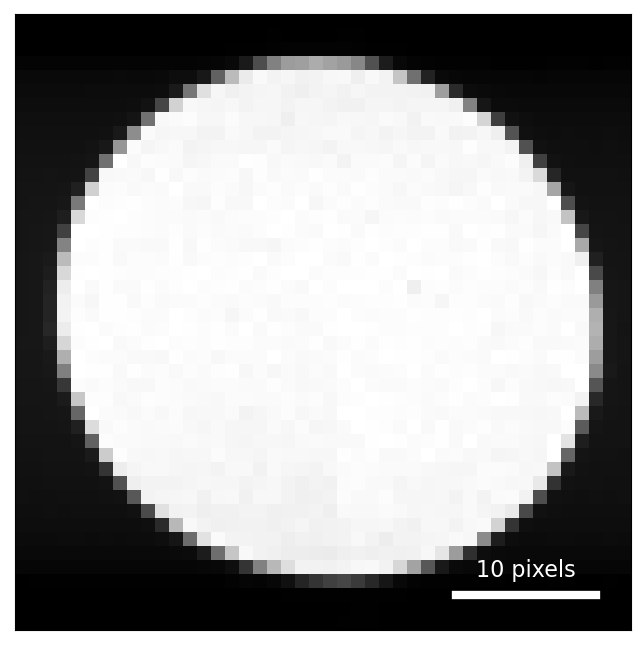

In [4]:
dataset.get_dp_mean();
py4DSTEM.show(
    dataset.tree('dp_mean'),
    ticks=False
)

In the mean diffraction pattern image, we can clearly see the initial STEM probe. For a thin specimen, most of the electrons will remain inside the bright field (BF) disk, i.e. the angular range of the initial STEM beam). This means that changing the TEM camera length or cropping the dataset around the BF disk is reasonable, as is the case here.

We will estimate the size and center coordinates of our BF disk in pixels to obtain virtual images (and help us calibrate the data later)

3835.270055773407
Estimated probe radius = 18.93 pixels


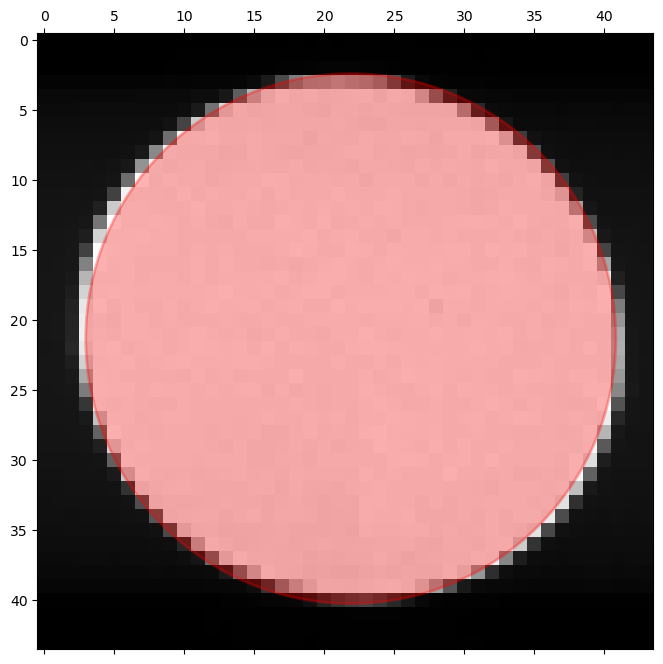

In [5]:
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size()

print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

By overlaying a circle, we can see a common artifact in STEM simulations: ellipticity of either the original probe aperture, or the projecter system of the TEM.  
This ellipticity will not affect our DPC measurement, although we should be careful to use a large enough virtual detector / cropping range to fully capture the BF signal for all probe positions.

Next, we create a BF virtual detector by expanding the detected radius slightly (+ 2px)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 64009/64009 [00:00<00:00, 116859.43it/s]


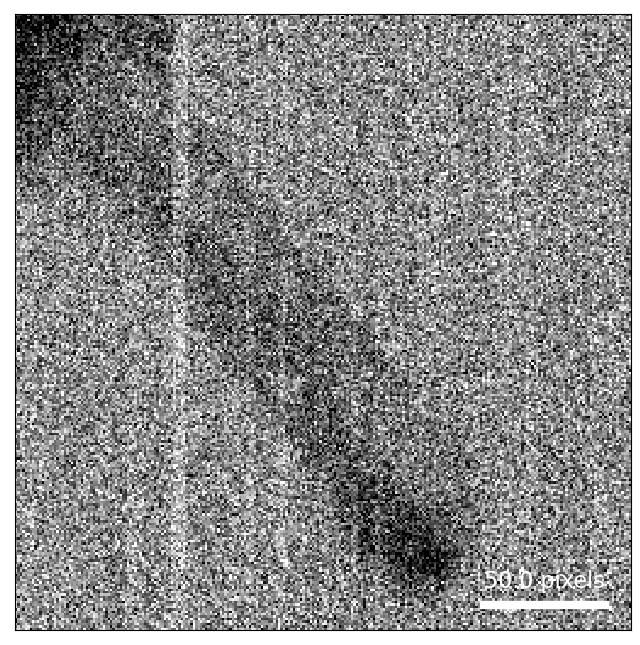

In [6]:
center = (probe_qx0, probe_qy0)
radius = probe_semiangle + 2

dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field'
);

py4DSTEM.show(
    dataset.tree('bright_field'),
    ticks=False,
)

Virtually no contrast is visible in the virtual BF image - this image contrast roughly corresponds to the `amplitude` of the sample's exit wave. In the following sections, we will use CoM-DPC to measure the `phase`, which will hopefully produce significantly more signal in the image.

# Part 1 - Calculate the CoM for each probe position. <a class="anchor" id="part_01"></a>

In this section, we will compute the (qx_shift, qy_shift) momentum vector estimate for all probe positions. We accomplish this by computing the first moment of the intentisty distribution in the x and y directions.

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:298: UserWarning: Iterative reconstruction will not be quantitative unless you specify real-space calibrations in 'A'
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:362: UserWarning: Iterative reconstruction will not be quantitative unless you specify appropriate reciprocal-space calibrations
  warnings.warn(


Best fit rotation = -12 degrees.
No need to transpose diffraction intensities.


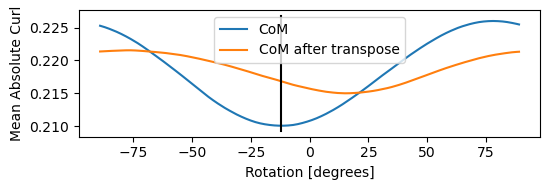

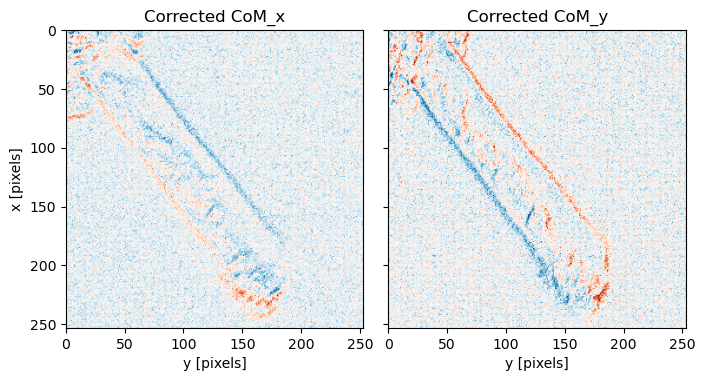

In [7]:
dpc = py4DSTEM.process.phase.DPCReconstruction(
    datacube=dataset,
    energy=80e3,
    verbose=True,
).preprocess()

Note that the DPC module warns you that the reconstruction will not be quantitative if we do not specify both the step size of the STEM probe, and the pixel size of the diffraction space images. By quantitative, we mean that the reconstruct phase values are properly reconstructed in radians, as opposed to a more qualitative phase image.

We also automatically estimate the rotation between real and reciprocal space, which in this case is a small -12 degrees - we can see that the corrected CoM images are nearly identical to the normalized CoM images.  This slight misalignment between the STEM scan direction and diffraction patterns will not affect a DPC reconstruction very much, but could strongly affect the ptychographic reconstruction below.

Before we reconstruct the phase, we can visualize the electic field magnitude of the sample from the CoM gradients directly:

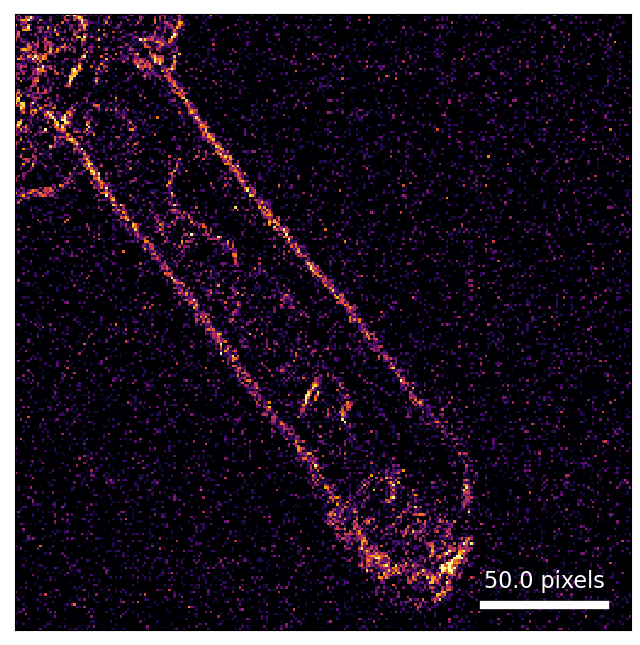

In [8]:
py4DSTEM.show(
    (dpc.com_x**2 + dpc.com_y**2)**0.5,
    cmap='inferno',
    vmin=0.7,
    vmax=0.999,
    ticks=False,
    scalebar=True,
)

# Part 2 - Reconstruct the phase using DPC. <a class="anchor" id="part_02"></a>

The final step is to invert the above gradient measurements into the underlying scalar field, the phase shift or potential of the sample.

### Brief description of our phase reconstruction method

The CoM DPC signal measures the gradient of the sample's potential. If we had the potential, we could differentiate it numerically to obtain this gradient. We want to go the other direction however. We could in principle write down the series of linear equations for the center-difference numerical gradient operator, and solve for all of the pixels by inverting this sparse matrix (with some assumptions at the boundaries).  However constructing this matrix is tedious, and it's fairly unstable without regularzation. 

Fortunately, there is a better way! As in most microscopy data analysis problems, we will use Fourier transforms. Essentially, we will compute the "inverse gradient" to reconstruct the DPC phase signal.  For more information, see:
B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

Reconstructing phase: 100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.77 iter/s]


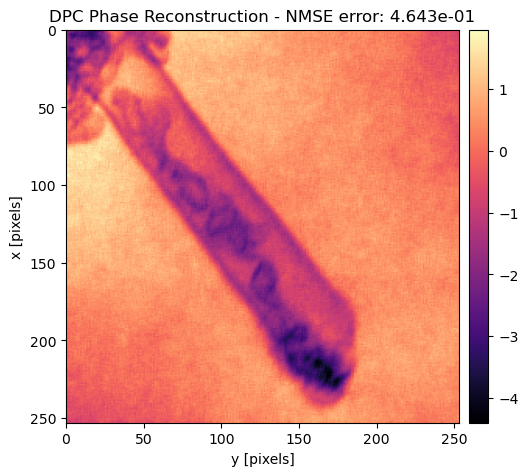

In [9]:
dpc.reconstruct(
    max_iter=32,
    reset=True,
    gaussian_filter_sigma = 0.375, # in pixels since we haven't calibrated
).visualize(
    figsize=(6,6),
    cbar=True,
);

Note that the phase signal is flipped - the nanotube phase is lower than the surrounding vacuum. Because our sample consists of positive ionic cores screened by negative electron orbitals, the sample's electroscatic potential should always be >=0, and therefore the object wave's phase shift should also be positive.

This is an unphysical artifact, which is caused by rotating the diffraction patterns by 180 degrees. Our direction-finding routine above cannot solve for this 180 degree rotation ambiguity - instead it is up to the user to fix it! We can apply this 180 flip in the preprocessing step: 

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:298: UserWarning: Iterative reconstruction will not be quantitative unless you specify real-space calibrations in 'A'
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:362: UserWarning: Iterative reconstruction will not be quantitative unless you specify appropriate reciprocal-space calibrations
  warnings.warn(


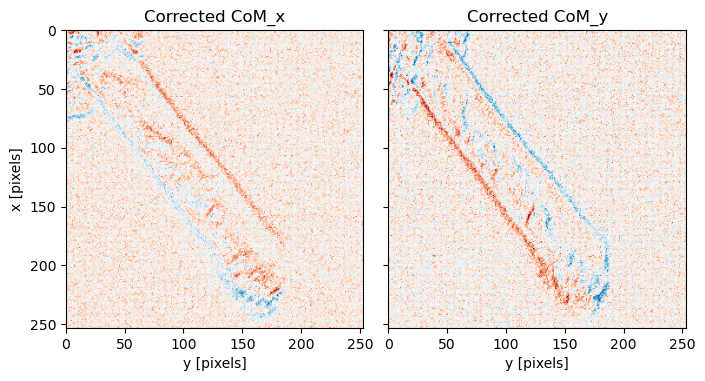

In [10]:
dpc_180 = py4DSTEM.process.phase.DPCReconstruction(
    datacube=dataset,
    energy=80e3,
    verbose=False,
).preprocess(
    force_com_rotation = np.rad2deg(dpc._rotation_best_rad) + 180.0,
    force_com_transpose = False,
)

Reconstructing phase: 100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.64 iter/s]


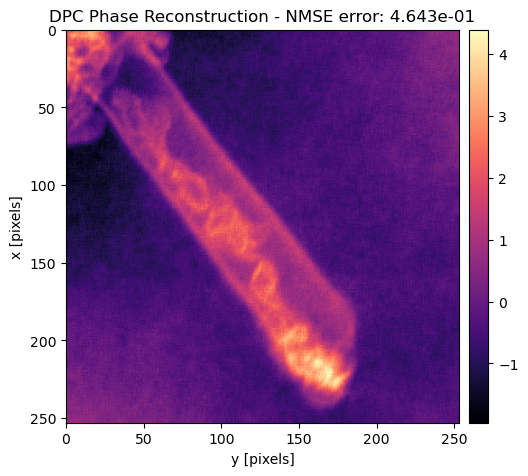

In [11]:
dpc_180.reconstruct(
    reset=True,
    max_iter=32,
    gaussian_filter_sigma = 0.375, # in pixels since we haven't calibrated
).visualize(
    figsize=(6,6),
    cbar=True,
);

Looks very good!  Now the phase shift of the object is positive everywhere. The main remianing artifact is the slowly varying phase out in the vacuum - this is because DPC is not very accurate at recovering the lowest spatial frequencies, which correspond to the long period wavelengths which cover the field of view.

# Part 3 - Ptychographic Reconstruction <a class="anchor" id="part_03"></a>

DPC reduces each diffraction pattern to just 2 numbers: the average momentum in the x and y directions (the center of mass). Our measured diffraction patterns however contain a lot more information - enough information in fact to fully deconvolve the probe wavefunction from the object wave. In this section, we will perform a ptychographic reconstruction of the nanotube.

### Brief algorithm description

In py4DSTEM, we typically use parallel update gradient descent, with alternating iterative updates of the object wave and probe. We simulate the propagation of the probe through the object wave, and then calculate the error relative to the measured diffraction pattern intensities. This error is used to calculate a gradent update step for the object wave. A similar process is used to update the probe wave, and we alternate these updates until convergence.

The diffraction space sampling of this dataset is much higher than it needs to be - this experiment was performed with the probe nearly in focus. Therefore we will also bin the data significantly to speed up the reconstruction.

First let's manually determine the pixel size in diffraction space.  
Above we estimated a probe semiangle of 19 pixels, and the HDF5 file says the probe is 26 mrads, for an accelerating voltage of 80 keV.  
At 80 keV, the wavelength is 0.04176 Angstroms.  We can therefore get q_probe as:

In [12]:
q_probe = (26/1000) / 0.04176
k_sampling = q_probe / 19
print('Diffraction space pixel size = ' + str(np.round(k_sampling,decimals=3)) + ' 1/A')

Diffraction space pixel size = 0.033 1/A


Next, we will bin and pad the data.  
We can bin the data because the probe is close to zero defocus, and therefore has a small spatial extent.  
We can pad the data because the step size is smaller than the maximum real space sampling implied by k_max in diffraction space.

In [13]:
bin_factor = 6
pad_factor = 2

dataset_bin_pad = dataset.copy()
dataset_bin_pad.bin_Q(bin_factor)
dataset_bin_pad.pad_Q(pad_factor);

We can now specify our calibrations:

In [14]:
dataset_bin_pad.calibration.set_Q_pixel_size(k_sampling * bin_factor)
dataset_bin_pad.calibration.set_Q_pixel_units('A^-1')
dataset_bin_pad.calibration.set_R_pixel_size(0.28)
dataset_bin_pad.calibration.set_R_pixel_units('A')
dataset_bin_pad.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.19661222020568664
             R_pixel_size:      0.28
             Q_pixel_units:     A^-1
             R_pixel_units:     A
             probe_semiangle:   18.932967857219836
             qx0_mean:          21.31824993190839
             qy0_mean:          21.882612741937233
)

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:590: UserWarning: Best fit rotation forced to 168 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:604: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


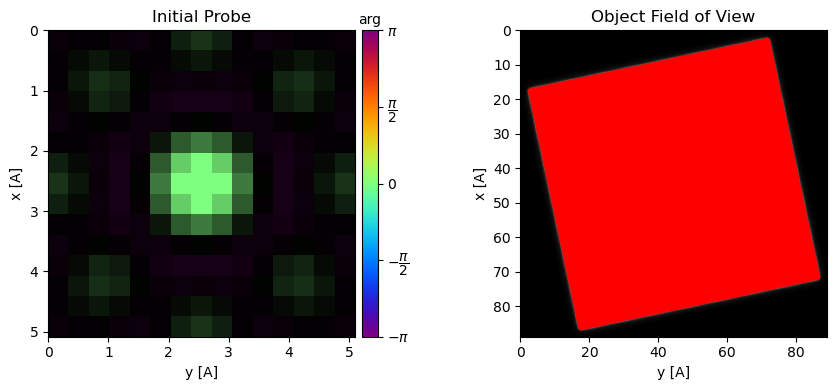

In [15]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset_bin_pad,
    verbose=True,
    energy=80e3,
    semiangle_cutoff=26,
    defocus=0,
    #device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation = False,
    force_com_rotation = np.rad2deg(dpc._rotation_best_rad) + 180.0,
    force_com_transpose = False,
    plot_probe_overlaps = True,
)

Next lets check to make sure our probe semiangle is a good initial guess for the probe, by comparing it to the experimental mean diffraction pattern:

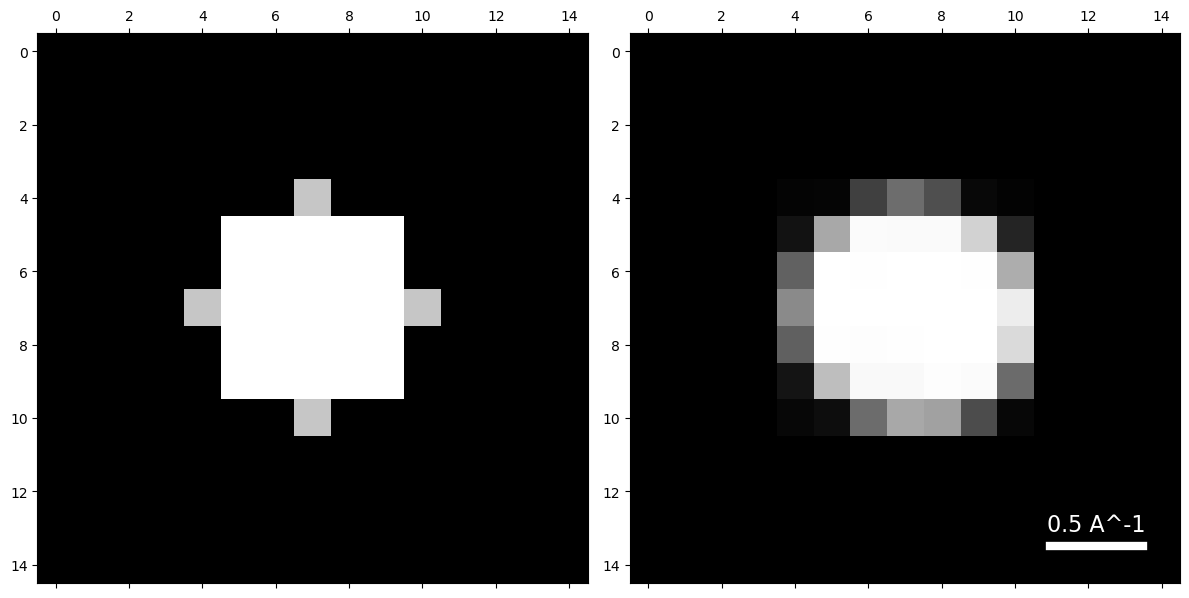

In [16]:
py4DSTEM.show([
    np.abs(ptycho.probe_fourier),
    dataset_bin_pad.get_dp_mean()
])

Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.2.


Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.23 iter/s]


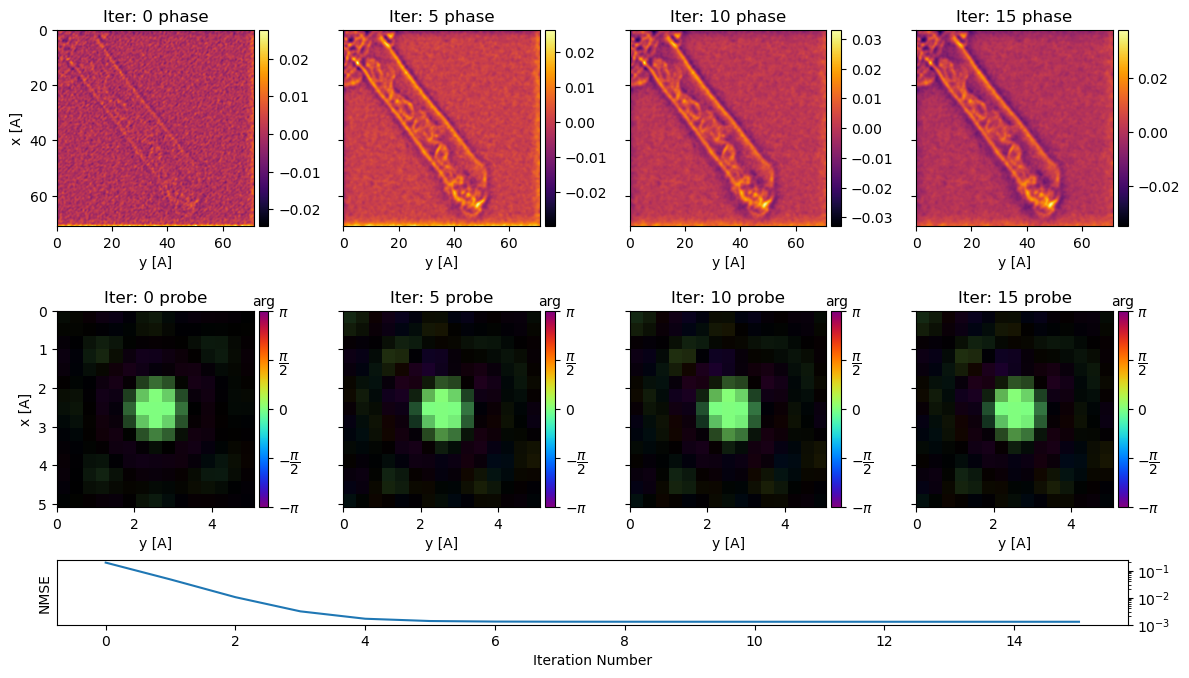

In [17]:
ptycho = ptycho.reconstruct(
    reset=True,
    progress_bar = True,
    store_iterations = True,
    max_iter = 16,
    pure_phase_object_iter = 4,
    step_size = 0.5,
    normalization_min = 0.2,
    gaussian_filter_sigma = 0.25, # in A
).visualize(
    iterations_grid='auto',
)

Let's take a closer look at the phase reconstruction:

(Min,Max) Amplitude: (0.9794,1.0)


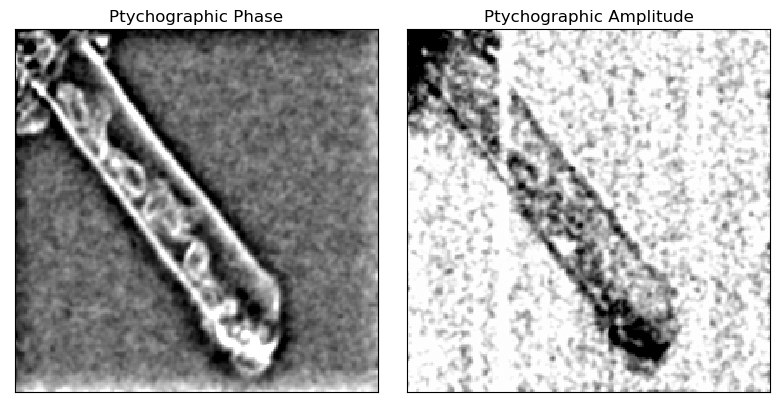

In [18]:
obj = ptycho.object_cropped
print(f'(Min,Max) Amplitude: ({np.abs(obj).min():.4},{np.abs(obj).max():.4})')

py4DSTEM.show(
    [
        np.angle(obj),
        np.abs(obj),
    ],
    title = ['Ptychographic Phase', 'Ptychographic Amplitude'],
    ticks=False,
    axsize=(4,4),
)

Note that we recovered a complex object above with only minor variations in amplitude, this suggests our CNT can confidently be approximated as a pure-phase object.  
In py4DSTEM this can be achieved one of two ways:
- Setting `pure_phase_object_iter` equal to `max_iter`
- Using `object_type="potential"`  

The latter will also allow us to enforce positivity and thus push the vacuum region to zero.  
Since we have already initialized our ptycho object, we can simply set `switch_object_iter=0` to switch to a real-valued potential object from the start (notice the printed summary):

Performing 0 iterations using a complex object type and 16 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 0.2.


Reconstructing object and probe: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.65 iter/s]


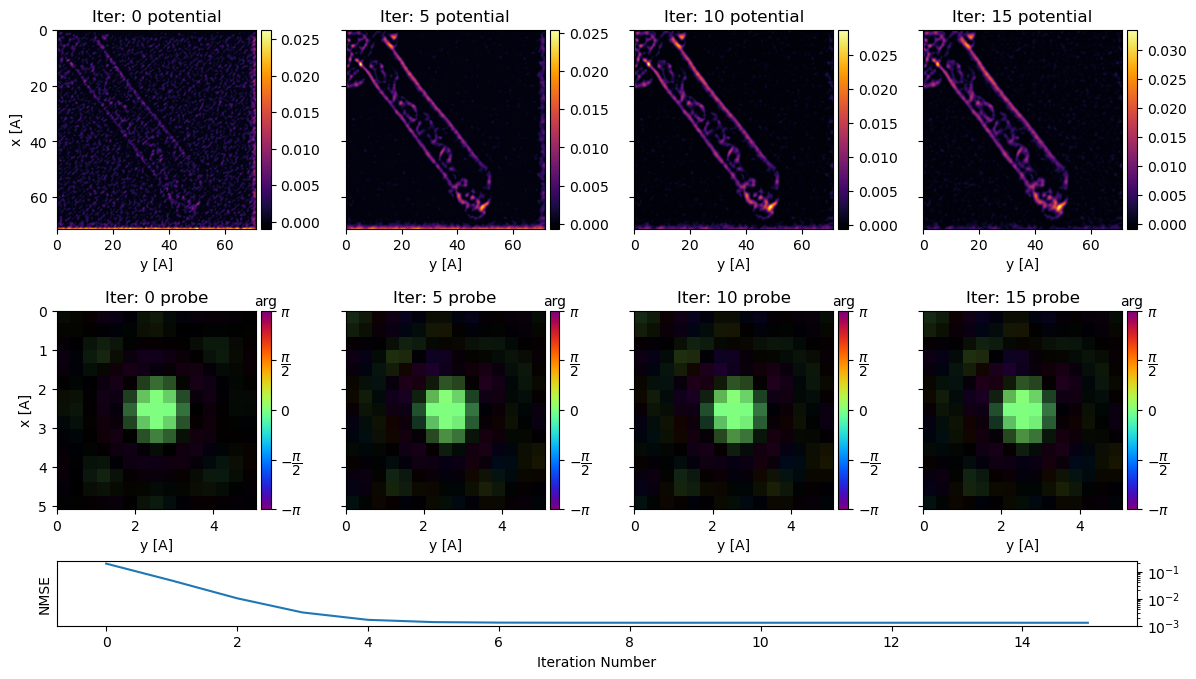

In [19]:
ptycho = ptycho.reconstruct(
    reset=True,
    progress_bar = True,
    store_iterations = True,
    max_iter = 16,
    step_size = 0.5,
    normalization_min = 0.2,
    gaussian_filter_sigma = 0.25, # in A
    switch_object_iter=0,
).visualize(
    iterations_grid='auto',
)

Indeed, we obtain an even sharper reconstruction with most of the vacuum set to zero!

# Part 4 - Comparing DPC to ptychography <a class="anchor" id="part_04"></a>

When the probe is very close to zero defocus, we would not expect to see much difference between DPC and ptychography. Ptychography may be a little bit sharper due to its ability to deconvolve the probe aberrations, but DPC can more easily recover lower spatial frequencies (though often with some artifacts!)  Here we will compare the two reconstructions.

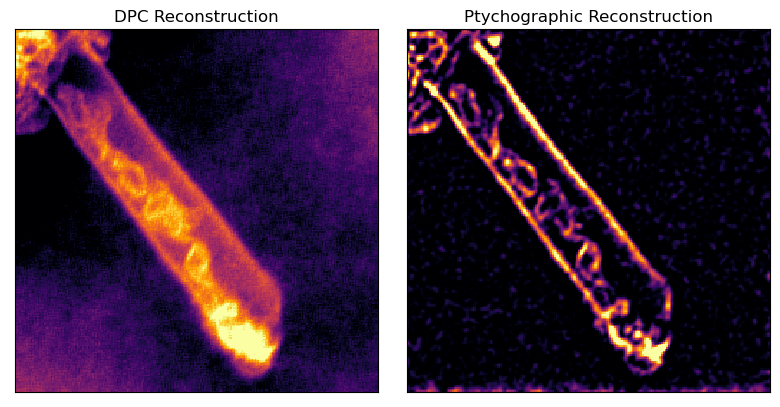

In [20]:
py4DSTEM.show([
    dpc_180.object_phase,
    ptycho.object_cropped,
    ],
    cmap = 'inferno',
    ticks=False,
    vmin=0.1,
    vmax=0.99,
    axsize=(4,4),
    title= ["DPC Reconstruction","Ptychographic Reconstruction"]
)


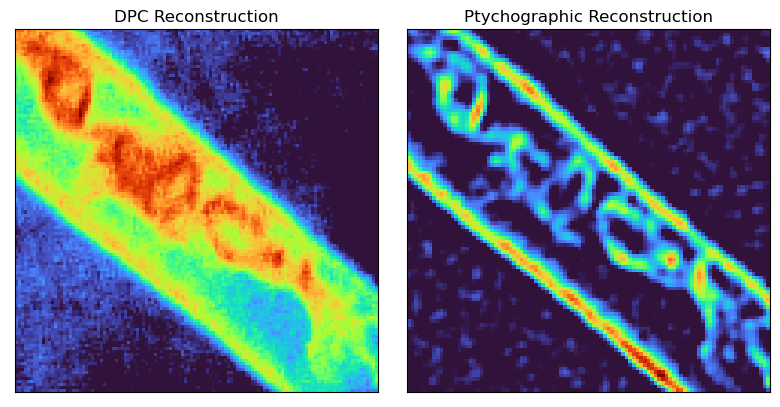

In [21]:
from scipy.ndimage import rotate

dpc_crop = rotate(dpc_180.object_phase,192)[95:215,125:245]
ptycho_crop = ptycho.object[85:185,110:210]

py4DSTEM.show([
    dpc_crop,
    ptycho_crop,
    ],
    cmap = 'turbo',
    ticks=False,
    vmin=0.2,
    vmax=1,
    axsize=(4,4),
    title= ["DPC Reconstruction","Ptychographic Reconstruction"]
)